Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Основная метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Вспомогательная метрика:
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

Сдача проекта:
1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb).
2. Приложить файл с названием по образцу PNagornyi_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

Сроки сдачи:
Сдать проект за 72 часа после Урока 10 ("Вебинар. Консультация по итоговому проекту").

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='svg'
from pylab import rcParams
rcParams['figure.figsize']=4, 3
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('train.csv')
data=df.copy()

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [4]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Чистим площадь

In [5]:
#выкидываем Healthcare_1
data.drop(['Healthcare_1'],axis=1, inplace=True) 

In [6]:
def clean_LifeSquare(df_to_clean,df_orig):
    #заменяем пустые значения LifeSquare на средние в зависимости от кол-ва комнат
    for i in range(20):
        df_to_clean.loc[df_to_clean.Rooms==i,'LifeSquare']=df_to_clean.loc[df_to_clean.Rooms==i,'LifeSquare'].fillna(df_orig.loc[df_orig.Rooms==i, 'LifeSquare'].mean())
    #заменяем экстремально высокие значения LifeSquare
    df_to_clean.loc[df_to_clean.LifeSquare>1000,'LifeSquare']=74.8
    # Заменяем аномальные площади на медианное значение LifeSquare
    for i in range(1,5):
        df_to_clean.loc[(df_to_clean.LifeSquare>140)&(df_to_clean.Rooms<4)&(df_to_clean.Rooms==i),'LifeSquare']=df_orig.loc[df_orig.Rooms==i,'LifeSquare'].median()
    #чистим площадь меньше 8 кв. м. - необходимо умножить площадь на 10. Повторяем два раза, чтобы вычистить площадь меьше 1
    for i in range(2):
        df_to_clean.loc[df_to_clean.LifeSquare<8,'LifeSquare']=df_to_clean.loc[df_to_clean.LifeSquare<8,'LifeSquare']*10
    df_to_clean['LifeSquare']=df_to_clean['LifeSquare'].fillna(df_orig['LifeSquare'].median())
    return print ('Done')

In [7]:
clean_LifeSquare(data,data)

Done


In [8]:
#есть выброс ID1981. Заменю его данные данными из ID 2388
data.loc[1981,['Rooms','Square','LifeSquare','KitchenSquare','Price']]=data.loc[2388,['Rooms','Square','LifeSquare','KitchenSquare','Price']]

#### Чистим комнаты

In [9]:
def clean_Rooms(df_to_clean):
    # Чистим количество комнат. Если комнат 0 или больше чем 6, то заменяем их значения
    df_to_clean.loc[(df_to_clean['Rooms']>5)|(df_to_clean['Rooms']==0)&(df_to_clean['LifeSquare']<30), 'Rooms']=1
    df_to_clean.loc[(df_to_clean['Rooms']>5)|(df_to_clean['Rooms']==0)&(df_to_clean['LifeSquare']>=30)&(df_to_clean['LifeSquare']<60), 'Rooms']=2
    df_to_clean.loc[(df_to_clean['Rooms']>5)|(df_to_clean['Rooms']==0)&(df_to_clean['LifeSquare']>=60)&(df_to_clean['LifeSquare']<90), 'Rooms']=3
    df_to_clean.loc[(df_to_clean['Rooms']>5)|(df_to_clean['Rooms']==0)&(df_to_clean['LifeSquare']>=90), 'Rooms']=4
    return print ('Done')

In [10]:
clean_Rooms(data)

Done


#### Чистим общую площадь

In [11]:
def clean_Square(df_to_clean):
    #заменяем выбросы по  площади больше 150
    df_to_clean.loc[(df_to_clean.Square>150)&(df_to_clean.Rooms<4)&(df_to_clean.LifeSquare<100),'Square']=df_to_clean.Rooms*40+20
    df_to_clean.loc[(df_to_clean.Square>275)&(df_to_clean.Rooms>=4),'Square']=df_to_clean.Rooms*40+20
    #меняем выбросы по  площади меньше 15
    df_to_clean.loc[df_to_clean.Square<15,'Square']=df_to_clean.LifeSquare+10
    #заменяем выбросы по площади меньшей жилой площади
    df_to_clean.loc[(df_to_clean.Square<df_to_clean.LifeSquare),'Square']=df_to_clean.LifeSquare+10
    index=df_to_clean.loc[df_to_clean.Square>180].index
    df_to_clean.loc[index,'LifeSquare']=df_to_clean.loc[index,'Rooms']*25
    df_to_clean.loc[index,'Square']=df_to_clean.loc[index,'Rooms']*25+15
    df_to_clean.loc[index,'KitchenSquare']=15
    return print ('Done')

In [12]:
clean_Square(data)

Done


In [13]:
#есть выпад по ID3368. Логичней заменить количество комнат с 1 до 5
data.loc[3368,'Rooms']=5

#### Чистим площадь кухни

In [14]:
def clean_KitchenSquare(df_to_clean,df_orig):
    #заменяем аномально большие площади кухонь на медиану
    for i in range(1,4):
        df_to_clean.loc[(df_to_clean.KitchenSquare>25)&(df_to_clean.Rooms==i),'KitchenSquare']=df_orig.loc[df_orig.Rooms==i,'KitchenSquare'].median()
    # заменяем аномально низкие площади кухонь на медиану 
    for i in range(1,6):
        df_to_clean.loc[(df_to_clean.KitchenSquare<5)&((df_to_clean.Square-df_to_clean.LifeSquare)>5)&(df_to_clean.Rooms==i),'KitchenSquare']=df_orig.loc[df_orig.Rooms==i,'KitchenSquare'].median()
    #Заменяем нулевую площадь на единицу
    df_to_clean.loc[df_to_clean.KitchenSquare<1,'KitchenSquare']=1
    df_to_clean.loc[df_to_clean.KitchenSquare>22,'KitchenSquare']=20
    return print ('Done')

In [15]:
clean_KitchenSquare(data,data)

Done


#### Чистим этажность дома

In [16]:
def clean_HouseFloor(df_to_clean):
    #чистим нулевые этажи и этажи выше 80
    df_to_clean.loc[df_to_clean.HouseFloor==0,'HouseFloor']=df_to_clean.loc[df_to_clean.HouseFloor==0,'Floor']
    df_to_clean.loc[df_to_clean.HouseFloor>80,'HouseFloor']=df_to_clean['Floor']
    return print ('Done')

In [17]:
clean_HouseFloor(data)

Done


#### Чистим год дома

In [18]:
def clean_HouseYear(df_to_clean):
    df_to_clean.loc[df_to_clean.HouseYear>2020,'HouseYear']=2020
    return print ('Done')

In [19]:
clean_HouseYear(data)

Done


### Создаем среднюю цену

In [20]:
#создаем новый столбец со средними ценами в зависимости от района
median_price=data.groupby(['DistrictId','Rooms'], 
                          as_index=False)[['Price']].median().rename(columns={'Price':'Median_price'})

data=data.merge(median_price, on=['DistrictId','Rooms'], how='left')

In [21]:
data.loc[data.DistrictId<3,['DistrictId','Rooms','Price','Median_price']].head(2)

,DistrictId,Rooms,Price,Median_price
8,1,2.0,229102.795999,202706.090239
20,0,3.0,521919.057400,300610.359425


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
Median_price     10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.6+ MB


In [23]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price,Median_price
count,10000.00000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.88910,56.747856,36.412652,7.160500,8.526700,12.822600,1984.872400,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300,214129.837141,211493.537594
std,4859.01902,43.587592,0.81306,18.687548,15.519330,2.567567,5.241148,6.338229,18.416347,0.119025,17.532614,4006.799803,23.831875,1.493601,4.806341,92868.119330,76551.802535
min,0.00000,0.000000,1.00000,16.117154,8.731467,1.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028,82342.775873
25%,4169.50000,20.000000,1.00000,42.169344,25.159008,6.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942,165071.825722
50%,8394.50000,36.000000,2.00000,53.249123,33.712631,7.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879,195474.299127
75%,12592.50000,75.000000,2.00000,66.483752,44.787743,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249116.513046,241068.903045
max,16798.00000,209.000000,5.00000,170.016872,138.910187,22.000000,42.000000,48.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570,624156.003381


## Строим модели

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso


In [25]:
#разбиваем object на dummy переменные
data=pd.get_dummies(data)

#### Смотрим корреляцию признаков

In [26]:
rcParams['figure.figsize']=12, 7

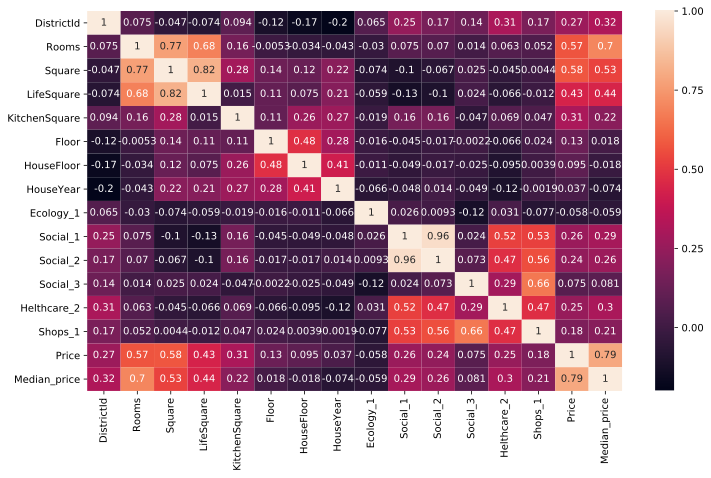

In [27]:
sns.heatmap(data[['DistrictId','Rooms','Square',
        'LifeSquare', 'KitchenSquare','Floor',
        'HouseFloor', 'HouseYear', 'Ecology_1', 
        'Social_1', 'Social_2','Social_3',
        'Helthcare_2', 'Shops_1','Price','Median_price'  
        ]].corr(),
                 cbar=True,
                 annot=True)

#### Линейная регрессия

In [28]:
data.keys()

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1', 'Price', 'Median_price',
       'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
       'Shops_2_B'],
      dtype='object')

In [29]:
# data.info()

In [30]:
X=data[['DistrictId','Rooms','Square',
        'LifeSquare', 'KitchenSquare','Floor',
        'HouseFloor', 'HouseYear', 'Ecology_1', 
        'Social_1', 'Social_2','Social_3',
        'Helthcare_2', 'Shops_1','Median_price',  
        'Ecology_2_A','Ecology_2_B', 'Ecology_3_A', 
        'Ecology_3_B', 'Shops_2_A', 'Shops_2_B']]

y=data['Price']
names=X.keys()

In [31]:
# X.head()

In [32]:
#Создаем модель и обучаем ее 
lr=LinearRegression()
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=42)
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [33]:
lr_y_pred=lr.predict(X_test)
lr_y_pred

array([159334.49342895, 263213.07496853, 229506.46562544, ...,
       269781.03097375, 121959.20701475, 242632.44514449])

In [34]:
from sklearn.metrics import r2_score

In [35]:
r2_score(y_test,lr_y_pred)

0.6762099038363643

In [36]:
lr_score=r2_score(y_test,lr_y_pred)
lr_score

0.6762099038363643

In [37]:
rcParams['figure.figsize']=20, 3

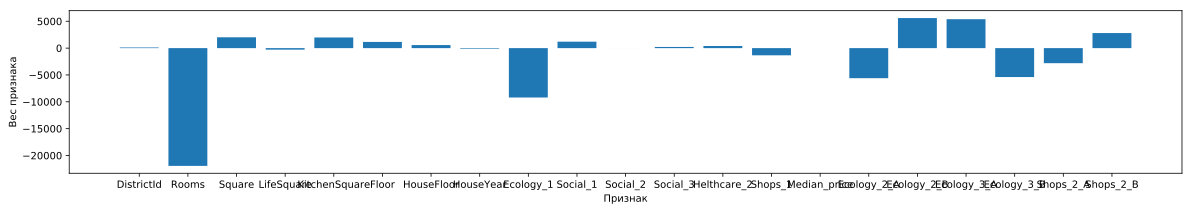

In [38]:
# строим диаграмму по коэффициентам
plt.bar(names, lr.coef_.flatten())

plt.ylabel("Вес признака")
plt.xlabel("Признак")

plt.show()

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#### Ridge

In [40]:
rdge=Ridge()

In [41]:
rdge.fit(X_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [42]:
rdge_y_pred=rdge.predict(X_test)

In [43]:
rdge_score=r2_score(y_test,rdge_y_pred)
r2_score(y_test,rdge_y_pred)

0.6762153679402108

In [44]:
rdge.coef_

array([ 1.20519847e+02, -2.19221536e+04,  2.01713640e+03, -2.83587292e+02,
        1.98321326e+03,  1.15424053e+03,  5.67257685e+02, -1.12604825e+02,
       -9.09660271e+03,  1.20003152e+03, -2.33048022e+00,  2.17629360e+02,
        3.91911043e+02, -1.33852358e+03,  8.05244951e-01, -5.56243473e+03,
        5.56243473e+03,  5.36734077e+03, -5.36734077e+03, -2.80097601e+03,
        2.80097601e+03])

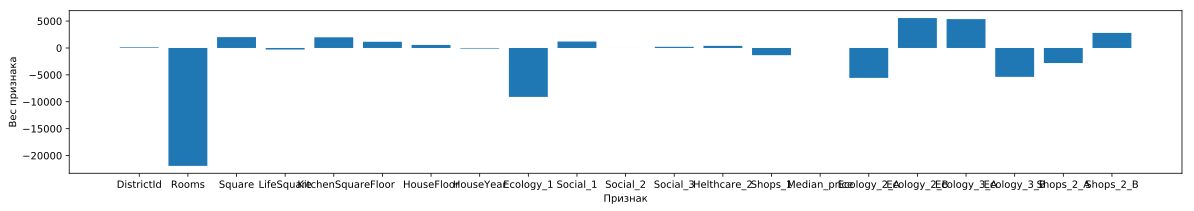

In [45]:
# строим диаграмму по коэффициентам
plt.bar(names, rdge.coef_.flatten())

plt.ylabel("Вес признака")
plt.xlabel("Признак")

plt.show()

In [46]:
# Отбираем важные коэффициенты 
important_features = [
    feature
    for feature, weight in zip(names, rdge.coef_.flatten())
    if np.abs(weight) > 1500
]

print(important_features)

['Rooms', 'Square', 'KitchenSquare', 'Ecology_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B']


In [47]:
# Повторяем модель для важных коэффициентов
rdge.fit(X_train.loc[:,important_features],y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [48]:
rdge_y_pred=rdge.predict(X_test.loc[:,important_features])

In [49]:
r2_score(y_test,rdge_y_pred)

0.40524176962910985

#### Lasso

In [50]:
lsso=Lasso()

In [51]:
lsso.fit(X_train,y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [52]:
lsso_y_pred=lsso.predict(X_test)

In [53]:
lsso_score=r2_score(y_test,lsso_y_pred)
r2_score(y_test,lsso_y_pred)

0.676214473880169

In [54]:
print(lr_score, rdge_score, lsso_score)

0.6762099038363643 0.6762153679402108 0.676214473880169


#### Random forest

In [55]:
from sklearn.ensemble import RandomForestRegressor

In [56]:
from sklearn.model_selection import GridSearchCV

In [57]:
#Зададим сетку параметров, по которой мы хотели бы провести поиск:
parameters = {
    'n_estimators': [150, 200, 250],
    'max_features': np.arange(5, 9),
    'max_depth': np.arange(5, 10),
}

rfr = GridSearchCV(
    estimator=RandomForestRegressor(n_jobs=-1),
    param_grid=parameters,
    scoring='r2',
    cv=5,
)

In [58]:
%%time
rfr.fit(X_train,y_train)

Wall time: 3min 30s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [150, 200, 250], 'max_features': array([5, 6, 7, 8]), 'max_depth': array([5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [59]:
cv_results = pd.DataFrame(rfr.cv_results_)

cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [60]:
# cv_results.head()

In [61]:
param_columns = [column  for column in cv_results.columns if column.startswith('param_')]

score_columns = ['mean_test_score', 'mean_train_score']

cv_results = (cv_results[param_columns + score_columns]
              .sort_values(by=score_columns, ascending=False))

cv_results.tail(10)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,mean_train_score
11,5,8,250,0.709256,0.740888
8,5,7,250,0.706592,0.736995
6,5,7,150,0.706356,0.736546
7,5,7,200,0.706052,0.736179
3,5,6,150,0.700920,0.729680
5,5,6,250,0.700692,0.730595
4,5,6,200,0.700626,0.729851
1,5,5,200,0.693223,0.721674
2,5,5,250,0.692979,0.721484
0,5,5,150,0.692898,0.721627


In [62]:
rcParams['figure.figsize']=4, 3

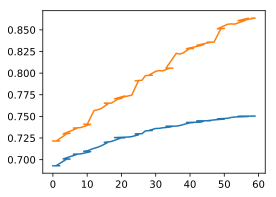

In [63]:
plt.plot(cv_results.index,cv_results.mean_test_score)
plt.plot(cv_results.index,cv_results.mean_train_score)
plt.show()

In [64]:
rfr.best_params_

{'max_depth': 9, 'max_features': 8, 'n_estimators': 200}

In [65]:
rfr=RandomForestRegressor(max_depth=9,max_features=8,n_estimators=200, n_jobs=-1)

In [66]:
%%time
rfr.fit(X_train,y_train)

Wall time: 686 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [67]:
rfr_y_pred=rfr.predict(X_test)


In [68]:
rfr_score=r2_score(y_test,rfr_y_pred)
rfr_score

0.7350312081626875

### Результаты

In [69]:
print(
    f' lr_score: {lr_score}\n rdge_score: {rdge_score}\n lsso_score: {lsso_score}\n rfr_score: {rfr_score}')


 lr_score: 0.6762099038363643
 rdge_score: 0.6762153679402108
 lsso_score: 0.676214473880169
 rfr_score: 0.7350312081626875


### Пробуем все четыре модели со стандартизацией

In [70]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [71]:
X_train_scaled=scaler.fit_transform(X_train)
X_train_scaled=pd.DataFrame(X_train_scaled,columns=names)
X_test_scaled=scaler.transform(X_test)
X_test_scaled=pd.DataFrame(X_test_scaled,columns=names)

Линейная регрессия

In [72]:
%%time
lr.fit(X_train_scaled,y_train)

Wall time: 7 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [73]:
lr_y_pred_scaled=lr.predict(X_test_scaled)

In [74]:
lr_score_scaled=r2_score(y_test,lr_y_pred_scaled)
lr_score_scaled

0.6762126695805759

Ridge

In [75]:
%%time
rdge.fit(X_train_scaled,y_train)

Wall time: 6 ms


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [76]:
rdge_y_pred_scaled=rdge.predict(X_test_scaled)

In [77]:
rdge_score_scaled=r2_score(y_test,rdge_y_pred_scaled)
rdge_score_scaled 

0.6762128115769059

Lasso

In [78]:
%%time
lsso.fit(X_train_scaled,y_train)

Wall time: 44 ms


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [79]:
lsso_y_pred_scaled=lsso.predict(X_test_scaled)

In [80]:
lsso_score_scaled=r2_score(y_test,lsso_y_pred_scaled)
lsso_score_scaled

0.6762113609015155

Random forest

In [81]:
#Зададим сетку параметров, по которой мы хотели бы провести поиск:
parameters = {
    'n_estimators': [150, 200, 250],
    'max_features': np.arange(5, 9),
    'max_depth': np.arange(5, 10),
}

rfr = GridSearchCV(
    estimator=RandomForestRegressor(n_jobs=-1),
    param_grid=parameters,
    scoring='r2',
    cv=5,
)

In [82]:
%%time
rfr.fit(X_train_scaled,y_train)

Wall time: 3min 29s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [150, 200, 250], 'max_features': array([5, 6, 7, 8]), 'max_depth': array([5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [83]:
rfr.best_params_

{'max_depth': 9, 'max_features': 8, 'n_estimators': 200}

In [84]:
rfr=RandomForestRegressor(
    max_depth=rfr.best_params_['max_depth'],
    max_features=rfr.best_params_['max_features'],
    n_estimators=rfr.best_params_["n_estimators"], 
    n_jobs=-1)

In [85]:
%%time
rfr.fit(X_train_scaled,y_train)

Wall time: 671 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [86]:
rfr_y_pred_scaled=rfr.predict(X_test_scaled)

In [87]:
rfr_score_scaled=r2_score(y_test,rfr_y_pred_scaled)
rfr_score_scaled

0.7337348206684879

### Результаты со стандартизацией

In [88]:
print(
    f' lr_score_scaled: {lr_score_scaled}\n rdge_score_scaled: {rdge_score_scaled}\n lsso_score_scaled: {lsso_score_scaled}\n rfr_score_scaled: {rfr_score_scaled}')


 lr_score_scaled: 0.6762126695805759
 rdge_score_scaled: 0.6762128115769059
 lsso_score_scaled: 0.6762113609015155
 rfr_score_scaled: 0.7337348206684879


### Пробуем все четыре модели с нормализацией

In [89]:
from sklearn.preprocessing import MinMaxScaler

In [90]:
scaler=MinMaxScaler()

In [91]:
X_train_minmax=scaler.fit_transform(X_train)
X_train_minmax=pd.DataFrame(X_train_minmax,columns=names)
X_test_minmax=scaler.transform(X_test)
X_test_minmax=pd.DataFrame(X_test_minmax,columns=names)

Линейная регрессия

In [92]:
%%time
lr.fit(X_train_minmax,y_train)

Wall time: 0 ns


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [93]:
lr_y_pred_minmax=lr.predict(X_test_minmax)

In [94]:
lr_score_minmax=r2_score(y_test,lr_y_pred_minmax)
lr_score_minmax

0.6762753541185883

Ridge

In [95]:
%%time
rdge.fit(X_train_minmax,y_train)

Wall time: 0 ns


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [96]:
rdge_y_pred_minmax=rdge.predict(X_test_minmax)

In [97]:
rdge_score_minmax=r2_score(y_test,rdge_y_pred_minmax)
rdge_score_minmax 

0.6761107329984154

Lasso

In [98]:
%%time
lsso.fit(X_train_minmax,y_train)

Wall time: 31.2 ms


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [99]:
lsso_y_pred_minmax=lsso.predict(X_test_minmax)

In [100]:
lsso_score_minmax=r2_score(y_test,lsso_y_pred_minmax)
lsso_score_minmax

0.6762195227149994

Random forest

In [101]:
#Зададим сетку параметров, по которой мы хотели бы провести поиск:
parameters = {
    'n_estimators': [150, 200, 250],
    'max_features': np.arange(5, 9),
    'max_depth': np.arange(5, 10),
}

rfr = GridSearchCV(
    estimator=RandomForestRegressor(n_jobs=-1),
    param_grid=parameters,
    scoring='r2',
    cv=5,
)

In [102]:
%%time
rfr.fit(X_train_minmax,y_train)

Wall time: 3min 29s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [150, 200, 250], 'max_features': array([5, 6, 7, 8]), 'max_depth': array([5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [103]:
rfr.best_params_

{'max_depth': 9, 'max_features': 8, 'n_estimators': 250}

In [104]:
rfr=RandomForestRegressor(
    max_depth=rfr.best_params_['max_depth'],
    max_features=rfr.best_params_['max_features'],
    n_estimators=rfr.best_params_["n_estimators"], 
    n_jobs=-1)

In [105]:
%%time
rfr.fit(X_train_minmax,y_train)

Wall time: 811 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [106]:
rfr_y_pred_minmax=rfr.predict(X_test_minmax)

In [107]:
rfr_score_minmax=r2_score(y_test,rfr_y_pred_minmax)
rfr_score_minmax

0.7341005924036142

### Результаты с нормализацией

In [108]:
print(
    f' lr_score_minmax: {lr_score_minmax}\n rdge_score_minmax: {rdge_score_minmax}\n lsso_score_minmax: {lsso_score_minmax}\n rfr_score: {rfr_score_minmax}')


 lr_score_minmax: 0.6762753541185883
 rdge_score_minmax: 0.6761107329984154
 lsso_score_minmax: 0.6762195227149994
 rfr_score: 0.7341005924036142


### Пробуем все четыре модели с Robust scaler

In [109]:
from sklearn.preprocessing import RobustScaler

In [110]:
scaler=RobustScaler()

In [111]:
type(scaler)

sklearn.preprocessing.data.RobustScaler

In [112]:
X_train_robust=scaler.fit_transform(X_train)
X_train_robust=pd.DataFrame(X_train_robust,columns=names)
X_test_robust=scaler.transform(X_test)
X_test_robust=pd.DataFrame(X_test_robust,columns=names)

Линейная регрессия

In [113]:
%%time
lr.fit(X_train_robust,y_train)

Wall time: 0 ns


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [114]:
lr_y_pred_robust=lr.predict(X_test_robust)

In [115]:
lr_score_robust=r2_score(y_test,lr_y_pred_robust)
lr_score_robust

0.6762099038363042

Ridge

In [116]:
%%time
rdge.fit(X_train_robust,y_train)

Wall time: 0 ns


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [117]:
rdge_y_pred_robust=rdge.predict(X_test_robust)

In [118]:
rdge_score_robust=r2_score(y_test,rdge_y_pred_robust)
rdge_score_robust 

0.6762183225291175

Lasso

In [119]:
%%time
lsso.fit(X_train_robust,y_train)

Wall time: 46.8 ms


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [120]:
lsso_y_pred_robust=lsso.predict(X_test_robust)

In [121]:
lsso_score_robust=r2_score(y_test,lsso_y_pred_robust)
lsso_score_robust

0.6762143794735059

Random forest

In [122]:
#Зададим сетку параметров, по которой мы хотели бы провести поиск:
parameters = {
    'n_estimators': [150, 200, 250],
    'max_features': np.arange(5, 9),
    'max_depth': np.arange(5, 10),
}

rfr = GridSearchCV(
    estimator=RandomForestRegressor(n_jobs=-1),
    param_grid=parameters,
    scoring='r2',
    cv=5,
)

In [123]:
%%time
rfr.fit(X_train_robust,y_train)

Wall time: 3min 30s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [150, 200, 250], 'max_features': array([5, 6, 7, 8]), 'max_depth': array([5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [124]:
rfr.best_params_

{'max_depth': 9, 'max_features': 8, 'n_estimators': 200}

In [125]:
rfr=RandomForestRegressor(
    max_depth=rfr.best_params_['max_depth'],
    max_features=rfr.best_params_['max_features'],
    n_estimators=rfr.best_params_["n_estimators"], 
    n_jobs=-1)

In [126]:
%%time
rfr.fit(X_train_robust,y_train)

Wall time: 646 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [127]:
rfr_y_pred_robust=rfr.predict(X_test_robust)

In [128]:
rfr_score_robust=r2_score(y_test,rfr_y_pred_robust)
rfr_score_robust

0.7343483422933457

### Результаты с Robust Scaler

In [129]:
print(
    f' lr_score_robust: {lr_score_robust}\n rdge_score_robust: {rdge_score_robust}\n lsso_score_robust: {lsso_score_robust}\n rfr_score_robust: {rfr_score_robust}')


 lr_score_robust: 0.6762099038363042
 rdge_score_robust: 0.6762183225291175
 lsso_score_robust: 0.6762143794735059
 rfr_score_robust: 0.7343483422933457


### Пробуем все четыре модели с PowerTransformer

In [130]:
from sklearn.preprocessing import PowerTransformer

In [131]:
scaler=PowerTransformer()

In [132]:
type(scaler)

sklearn.preprocessing.data.PowerTransformer

In [133]:
X_train_power=scaler.fit_transform(X_train)
X_train_power=pd.DataFrame(X_train_power,columns=names)
X_test_power=scaler.transform(X_test)
X_test_power=pd.DataFrame(X_test_power,columns=names)

Линейная регрессия

In [134]:
%%time
lr.fit(X_train_power,y_train)

Wall time: 15.6 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [135]:
lr_y_pred_power=lr.predict(X_test_power)

In [136]:
lr_score_power=r2_score(y_test,lr_y_pred_power)
lr_score_power

0.6555411790793519

Ridge

In [137]:
%%time
rdge.fit(X_train_power,y_train)

Wall time: 0 ns


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [138]:
rdge_y_pred_power=rdge.predict(X_test_power)

In [139]:
rdge_score_power=r2_score(y_test,rdge_y_pred_power)
rdge_score_power 

0.6555434938688831

Lasso

In [140]:
%%time
lsso.fit(X_train_power,y_train)

Wall time: 62.4 ms


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [141]:
lsso_y_pred_power=lsso.predict(X_test_power)

In [142]:
lsso_score_power=r2_score(y_test,lsso_y_pred_power)
lsso_score_power

0.6555414086107907

Random forest

In [143]:
#Зададим сетку параметров, по которой мы хотели бы провести поиск:
parameters = {
    'n_estimators': [150, 200, 250],
    'max_features': np.arange(5, 9),
    'max_depth': np.arange(5, 10),
}

rfr = GridSearchCV(
    estimator=RandomForestRegressor(n_jobs=-1),
    param_grid=parameters,
    scoring='r2',
    cv=5,
)

In [144]:
%%time
rfr.fit(X_train_power,y_train)

Wall time: 3min 30s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [150, 200, 250], 'max_features': array([5, 6, 7, 8]), 'max_depth': array([5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [145]:
rfr.best_params_

{'max_depth': 9, 'max_features': 8, 'n_estimators': 200}

In [146]:
rfr=RandomForestRegressor(
    max_depth=rfr.best_params_['max_depth'],
    max_features=rfr.best_params_['max_features'],
    n_estimators=rfr.best_params_["n_estimators"], 
    n_jobs=-1)

In [147]:
%%time
rfr.fit(X_train_power,y_train)

Wall time: 671 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [148]:
rfr_y_pred_power=rfr.predict(X_test_power)

In [149]:
rfr_score_power=r2_score(y_test,rfr_y_pred_power)
rfr_score_power

0.7358504348050221

### Результаты с PowerTransFormer

In [150]:
print(
    f' lr_score_power: {lr_score_power}\n rdge_score_power: {rdge_score_power}\n lsso_score_power: {lsso_score_power}\n rfr_score_power: {rfr_score_power}')


 lr_score_power: 0.6555411790793519
 rdge_score_power: 0.6555434938688831
 lsso_score_power: 0.6555414086107907
 rfr_score_power: 0.7358504348050221


### Оцениваем все результаты вместе

In [151]:
score_together={'Метод':['LinearRegression','Ridge','Lasso','RandomForest'],
 'Оригинал':[lr_score,rdge_score,lsso_score,rfr_score],
 'StandardScaler':[lr_score_scaled,rdge_score_scaled,lsso_score_scaled,rfr_score_scaled],
 'MinMaxScaler':[lr_score_minmax,rdge_score_minmax,lsso_score_minmax,rfr_score_minmax],
 'RobustScaler':[lr_score_robust,rdge_score_robust,lsso_score_robust,rfr_score_robust],
 'PowerTransFormer':[lr_score_power,rdge_score_power,lsso_score_power,rfr_score_power]}
score_table=pd.DataFrame(score_together)
score_table

,Метод,Оригинал,StandardScaler,MinMaxScaler,RobustScaler,PowerTransFormer
0,LinearRegression,0.676210,0.676213,0.676275,0.676210,0.655541
1,Ridge,0.676215,0.676213,0.676111,0.676218,0.655543
2,Lasso,0.676214,0.676211,0.676220,0.676214,0.655541
3,RandomForest,0.735031,0.733735,0.734101,0.734348,0.735850


Как можно увидеть, лучший результат выдает метод RandomForest с обработкой исходных данных по методу  PowerTransFormer

## Загрузим тестовый сет и подготовим его для обучения

In [152]:
dft=pd.read_csv('test.csv')
tdata=dft.copy()

In [153]:
tdata.loc[tdata['LifeSquare'].isnull()==True].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5,7633,53,1.0,40.675627,NaN,1.0,21,21.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
11,3310,6,3.0,84.625350,NaN,1.0,6,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
14,5214,27,1.0,37.555197,NaN,1.0,5,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
21,16688,1,1.0,44.878767,NaN,1.0,1,9.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B


In [154]:
tdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


In [155]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Price,Median_price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.00000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.88910,56.747856,36.412652,7.160500,8.526700,12.822600,1984.872400,0.118858,...,1.319500,4.231300,214129.837141,211493.537594,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,4859.01902,43.587592,0.81306,18.687548,15.519330,2.567567,5.241148,6.338229,18.416347,0.119025,...,1.493601,4.806341,92868.119330,76551.802535,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.00000,0.000000,1.00000,16.117154,8.731467,1.000000,1.000000,1.000000,1910.000000,0.000000,...,0.000000,0.000000,59174.778028,82342.775873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.00000,42.169344,25.159008,6.000000,4.000000,9.000000,1974.000000,0.017647,...,0.000000,1.000000,153872.633942,165071.825722,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,8394.50000,36.000000,2.00000,53.249123,33.712631,7.000000,7.000000,14.000000,1977.000000,0.075424,...,1.000000,3.000000,192269.644879,195474.299127,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,12592.50000,75.000000,2.00000,66.483752,44.787743,9.000000,12.000000,17.000000,2001.000000,0.195781,...,2.000000,6.000000,249116.513046,241068.903045,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,16798.00000,209.000000,5.00000,170.016872,138.910187,22.000000,42.000000,48.000000,2020.000000,0.521867,...,6.000000,23.000000,633233.466570,624156.003381,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [156]:
#выкидываем Healthcare_1
tdata.drop(['Healthcare_1'],axis=1, inplace=True) 

In [157]:
clean_LifeSquare(tdata,data)

Done


In [158]:
clean_Square(tdata)

Done


In [159]:
clean_Rooms(tdata)

Done


In [160]:
clean_KitchenSquare(tdata,data)

Done


In [161]:
clean_HouseFloor(tdata)

Done


In [162]:
clean_HouseYear(tdata)

Done


Создаем среднюю цену

In [163]:
#создаем новый столбец со средними ценами в зависимости от района
tdata=tdata.merge(median_price, on=['DistrictId','Rooms'], how='left')

In [164]:
tdata['Median_price']=tdata['Median_price'].fillna(data['Median_price'].mean())

In [165]:
tdata=pd.get_dummies(tdata)

### Обучаем модель и предсказываем цены на тестовый файл

In [166]:
test_X=tdata[['DistrictId','Rooms','Square',
        'LifeSquare', 'KitchenSquare','Floor',
        'HouseFloor', 'HouseYear', 'Ecology_1', 
        'Social_1', 'Social_2','Social_3',
        'Helthcare_2', 'Shops_1','Median_price',  
        'Ecology_2_A','Ecology_2_B', 'Ecology_3_A', 
        'Ecology_3_B', 'Shops_2_A', 'Shops_2_B']]


Для безопасности, обучим модель еще раз со всеми неободимыми параметрами на полной выборке

In [167]:
X=data[['DistrictId','Rooms','Square',
        'LifeSquare', 'KitchenSquare','Floor',
        'HouseFloor', 'HouseYear', 'Ecology_1', 
        'Social_1', 'Social_2','Social_3',
        'Helthcare_2', 'Shops_1','Median_price',  
        'Ecology_2_A','Ecology_2_B', 'Ecology_3_A', 
        'Ecology_3_B', 'Shops_2_A', 'Shops_2_B']]

y=data['Price']
names=X.keys()

In [168]:
scaler=PowerTransformer()

In [169]:
type(scaler)

sklearn.preprocessing.data.PowerTransformer

In [170]:
X_power=scaler.fit_transform(X)
X_power=pd.DataFrame(X_power,columns=names)

In [171]:
test_X_power=scaler.transform(test_X)
test_X_power=pd.DataFrame(test_X_power,columns=names)

In [172]:
# X_robust.describe()

In [173]:
rfr=RandomForestRegressor(
    max_depth=9,
    max_features=8,
    n_estimators=250, 
    n_jobs=-1)

In [174]:
%%time
rfr.fit(X_power,y)

Wall time: 998 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [175]:
test_pred=rfr.predict(test_X_power)

In [176]:
tdata['Price']=test_pred
tdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 23 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       5000 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Median_price     5000 non-null float64
Ecology_2_A      5000 non-null uint8
Ecology_2_B      5000 non-null uint8
Ecology_3_A      5000 non-null uint8
Ecology_3_B      5000 non-null uint8
Shops_2_A        5000 non-null uint8
Shops_2_B        5000 non-null uint8
Price            5000 non-null float64
dtypes: float64(8), int64(

In [177]:
tdata[['Id','Price']].to_csv('DSizov_predictions.csv',index=None)